In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
plt.rcParams.update({'font.size': 15})

In [3]:
run /home/chiveremote/pychfpga/pychfpga/sifpga_crs_corr_capture_sandbox.py

Enabling nested event loop on current loop ID 130094146081744
Adding new log handlers of <Logger pychfpga (WARNING)> with level debug
Opened TCPipe socket at ('192.168.0.2', 60622)


There are no IceCrates in the hardware map!


+--------------+-----------------+
| Standalone   | Virt. slot None |
| Motherboards | CRS_SN0023      |
|              | 192.168.250.11  |
+--------------+-----------------+
| Mezz1        | -               |
| Mezz2        | -               |
+--------------+-----------------+

Forcing output 0 mode to LVPECL because fout is high
Forcing output 8 mode to LVPECL because fout is high
Forcing output 9 mode to LVPECL because fout is high
Forcing output 10 mode to LVPECL because fout is high
Forcing output 11 mode to LVPECL because fout is high
Forcing output 12 mode to LVPECL because fout is high
TCPipe: Programming FPGA with 34437356 bytes


chFPGA(None, 'CRS_SN0023'): Sync is not yet implemented on the CRS
chFPGA(None, 'CRS_SN0023'): Sync is not yet implemented on the CRS
chFPGA(None, 'CRS_SN0023'): There is no 1st CROSSBAR module in this firmware build (so there can't be data streamed to the correlators or GPU links!)
chFPGA(None, 'CRS_SN0023'): There is no 2nd CROSSBAR module in this firmware build
chFPGA(None, 'CRS_SN0023'): There is no 3rd CROSSBAR module in this firmware build
{self!r}: Cannot set data width on UltraCT. Command is ignored. 
{self!r}: set_frames_per_packet is not implemented on UltraCT. Packet size is set through the playlist. Command is ignored. 
The platform does not support SYNC sources
chFPGA(None, 'CRS_SN0023'): Sync is not yet implemented on the CRS
chFPGA(None, 'CRS_SN0023'): Sync is not yet implemented on the CRS
FPGAArray(1_boards,0_crates): SYNC will not be checked as not all firmware have SYNC logic
chFPGA(None, 'CRS_SN0023'): Sync is not yet implemented on the CRS


-------------- CHAN[0].FFT STATUS --------------
 FFT Bypass: False
 FFT SHIFT schedule: 0x3FF8
 CASPER block pipeling delay: Measured=12533, set point=12533:  clocks
 Number of FFT overflows: 0
None
-------------- CHAN[1].FFT STATUS --------------
 FFT Bypass: False
 FFT SHIFT schedule: 0x3FF8
 CASPER block pipeling delay: Measured=12533, set point=12533:  clocks
 Number of FFT overflows: 0
None
-------------- CHAN[2].FFT STATUS --------------
 FFT Bypass: False
 FFT SHIFT schedule: 0x3FF8
 CASPER block pipeling delay: Measured=12533, set point=12533:  clocks
 Number of FFT overflows: 0
None
-------------- CHAN[3].FFT STATUS --------------
 FFT Bypass: False
 FFT SHIFT schedule: 0x3FF8
 CASPER block pipeling delay: Measured=12533, set point=12533:  clocks
 Number of FFT overflows: 2
None
-------------- CHAN[4].FFT STATUS --------------
 FFT Bypass: False
 FFT SHIFT schedule: 0x3FF8
 CASPER block pipeling delay: Measured=12533, set point=12533:  clocks
 Number of FFT overflows: 0
None


In [4]:
s_per_frame = 2**14*(1/(ccc.fs*1e6)) # samples/frame * seconds/sample. Make sure sampling frequency is in Hz
board_inputs = ['W6Y', 'W6X', 'E6Y', 'E6X', 'M6Y', 'M6X', 'Amplified Noise 1', 'Amplified Noise 2'] 

# Long FFT Measurements

In [5]:
for n in range(ccc.NPOLS):
    # Configure each FFT
    fft = ccc.i.chan[n].FFT
    # fft.FFT_SHIFT = 0b11111111111000
    fft.FFT_SHIFT = 0b00011111111111 # reverse the order
    print(fft.status())

-------------- CHAN[0].FFT STATUS --------------
 FFT Bypass: False
 FFT SHIFT schedule: 0x7FF
 CASPER block pipeling delay: Measured=12533, set point=12533:  clocks
 Number of FFT overflows: 0
None
-------------- CHAN[1].FFT STATUS --------------
 FFT Bypass: False
 FFT SHIFT schedule: 0x7FF
 CASPER block pipeling delay: Measured=12533, set point=12533:  clocks
 Number of FFT overflows: 0
None
-------------- CHAN[2].FFT STATUS --------------
 FFT Bypass: False
 FFT SHIFT schedule: 0x7FF
 CASPER block pipeling delay: Measured=12533, set point=12533:  clocks
 Number of FFT overflows: 0
None
-------------- CHAN[3].FFT STATUS --------------
 FFT Bypass: False
 FFT SHIFT schedule: 0x7FF
 CASPER block pipeling delay: Measured=12533, set point=12533:  clocks
 Number of FFT overflows: 255
None
-------------- CHAN[4].FFT STATUS --------------
 FFT Bypass: False
 FFT SHIFT schedule: 0x7FF
 CASPER block pipeling delay: Measured=12533, set point=12533:  clocks
 Number of FFT overflows: 0
None
---

In [7]:
n_fft_integrations = 500 # 30
n_fft_captures = 100
fft_integration_period = 2*n_fft_captures*s_per_frame # we capture two contiguous frames at a time, so we recover twice as many frames as captures
print(fft_integration_period)

0.001024


In [19]:
psd_fft = np.zeros((n_fft_integrations, ccc.NPOLS, len(ccc.f)))
kert_fft = np.zeros((n_fft_integrations, ccc.NPOLS, len(ccc.f)))
fft_cap_adc_ovflws = np.zeros((n_fft_integrations, ccc.NPOLS))
# fft_cap_adc_rms_power_dBm = np.zeros((n_adc_integrations, ccc.NPOLS))
fft_cap_fft_ovflws = np.zeros((n_fft_integrations, ccc.NPOLS))

for n in range(n_fft_integrations):
    print(f'{n}/{n_fft_integrations}')
    
    # Pulse the overflows resets
    for m in range(ccc.NPOLS):

        # Reset ADC stats capture (which is actually in the Scaler module)
        ccc.i.chan[m].SCALER.STATS_FRAME_COUNT = n_fft_captures
        ccc.i.chan[m].SCALER.STATS_CAPTURE = 0 # capture new stats
        # print(m, ccc.i.chan[m].SCALER.STATS_CAPTURE)
        ccc.i.chan[m].SCALER.STATS_CAPTURE = 1
        # print(m, ccc.i.chan[m].SCALER.STATS_CAPTURE)

        # Reset FFT overflow counter
        ccc.i.chan[m].FFT.OVERFLOW_RESET = 1 
        ccc.i.chan[m].FFT.OVERFLOW_RESET = 0

    # Capture data
    d_fft = ccc.read_fft_frames(ncap = n_fft_captures)
    psd_fft[n] = np.mean(np.abs(d_fft)**2, axis = 1)
    kert_fft[n] = np.mean(np.abs(d_fft)**4, axis = 1)

    # Measure ADC overflows
    for m in range(ccc.NPOLS):
        print('---')
        # print(m, ccc.i.chan[m].SCALER.STATS_CAPTURE)
        # print(ccc.i.chan[m].SCALER.STATS_READY)
        ctr = 0
        while True:
            if ccc.i.chan[m].SCALER.STATS_READY == 1:
                print(f'stats ready after {ctr} cycles')
                fft_cap_adc_ovflws[n, m] = ccc.i.chan[m].SCALER.STATS_ADC_OVERFLOWS
                break
            else:
                ctr += 1
                
    # Measure FFT overflows
    fft_cap_fft_ovflws[n] = [ccc.i.chan[m].FFT.OVERFLOW_COUNT for m in range(ccc.NPOLS)]

0/500
Flushed 1633 packets while emptying UDP buffers
Skipped 65 packets while waiting for a fresh timestamp
mode=0, 8 channel(s), 2 frames per channel, 100 captures
Chan 0: -5600.0 missing packets
Chan 1: -5600.0 missing packets
Chan 2: -5600.0 missing packets
Chan 3: -5600.0 missing packets
Chan 4: -5600.0 missing packets
Chan 5: -5600.0 missing packets
Chan 6: -5600.0 missing packets
Chan 7: -5600.0 missing packets
Timestamp differences: {3906}
---
stats ready after 0 cycles
---
stats ready after 0 cycles
---
stats ready after 0 cycles
---
stats ready after 0 cycles
---
stats ready after 0 cycles
---
stats ready after 0 cycles
---
stats ready after 0 cycles
---
stats ready after 0 cycles
1/500
Flushed 1637 packets while emptying UDP buffers
Skipped 65 packets while waiting for a fresh timestamp
mode=0, 8 channel(s), 2 frames per channel, 100 captures
Chan 0: -5600.0 missing packets
Chan 1: -5600.0 missing packets
Chan 2: -5600.0 missing packets
Chan 3: -5600.0 missing packets
Chan 4

/tmp/ipykernel_536555/1666417478.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4, 2, n + 1)


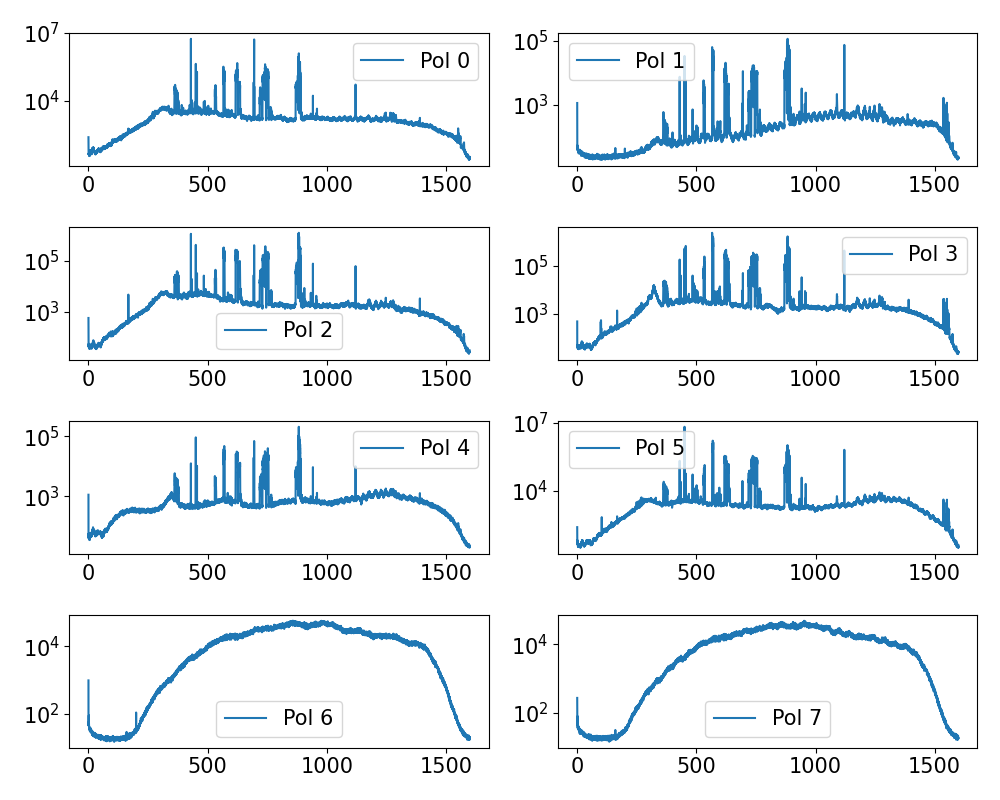

In [20]:
plt.figure(figsize = (10, 8))
plt.title('Integrated PSDs from Firmware FFTs')
for n in range(8):
    plt.subplot(4, 2, n + 1)
    plt.semilogy(ccc.f, psd_fft[0, n], label = f'Pol {n}')
    plt.legend()
plt.tight_layout()

/tmp/ipykernel_536555/1350809797.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4, 2, n + 1)


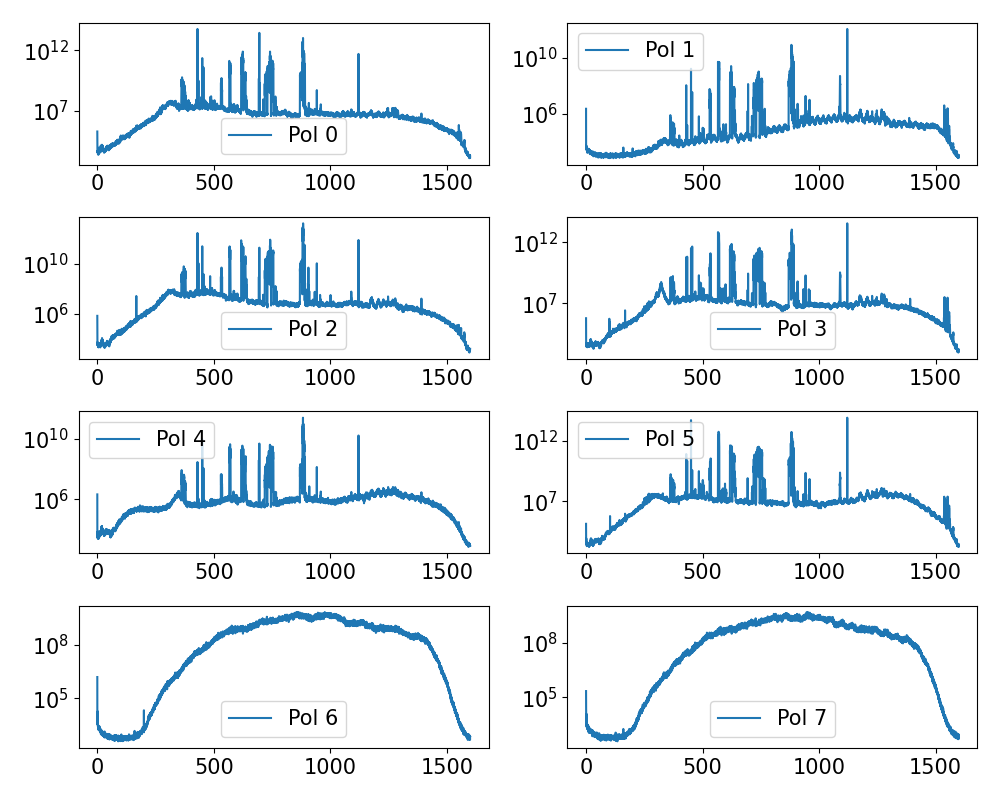

In [21]:
plt.figure(figsize = (10, 8))
plt.title('Integrated PSDs from Firmware FFTs')
for n in range(8):
    plt.subplot(4, 2, n + 1)
    plt.semilogy(ccc.f, kert_fft[0, n], label = f'Pol {n}')
    plt.legend()
plt.tight_layout()

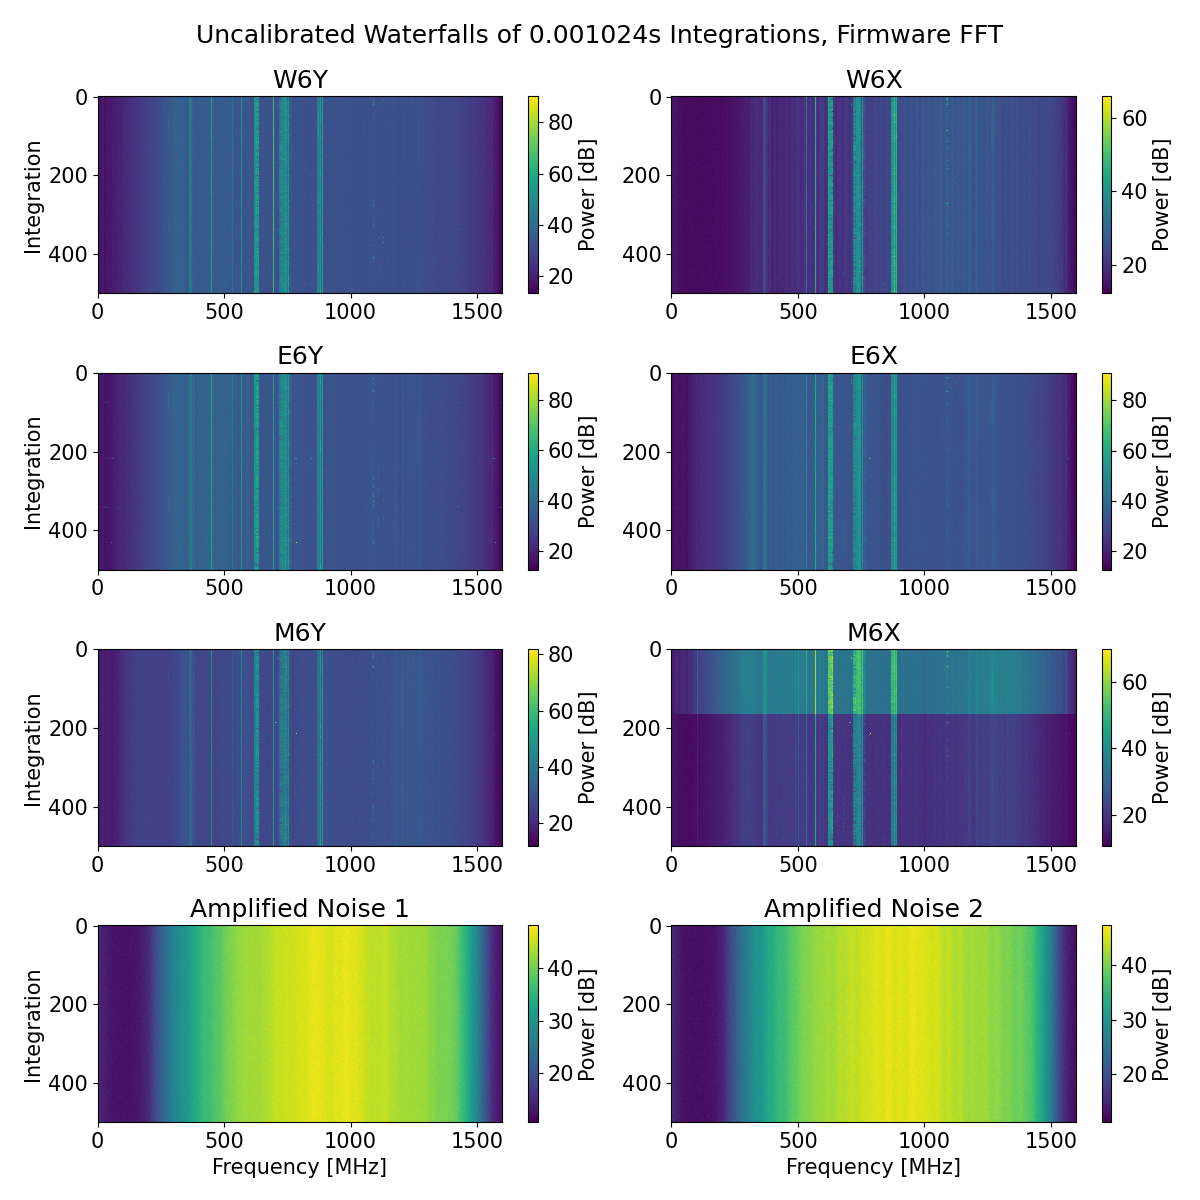

In [22]:
plt.figure(figsize = (12, 12))
plt.suptitle(f'Uncalibrated Waterfalls of {fft_integration_period}s Integrations, Firmware FFT')

for n in range(ccc.NPOLS):
    plt.subplot(4, 2, n + 1)
    plt.title(f'{board_inputs[n]}')
    plt.pcolormesh(ccc.f, np.arange(n_fft_integrations), 10*np.log10(psd_fft[:, n, :]))
    plt.colorbar(label = 'Power [dB]')
    if n == 0 or n == 2 or n == 4 or n == 6:
        plt.ylabel('Integration')
    if n == 6 or n== 7:
        plt.xlabel('Frequency [MHz]')
    plt.gca().invert_yaxis()
    plt.tight_layout()

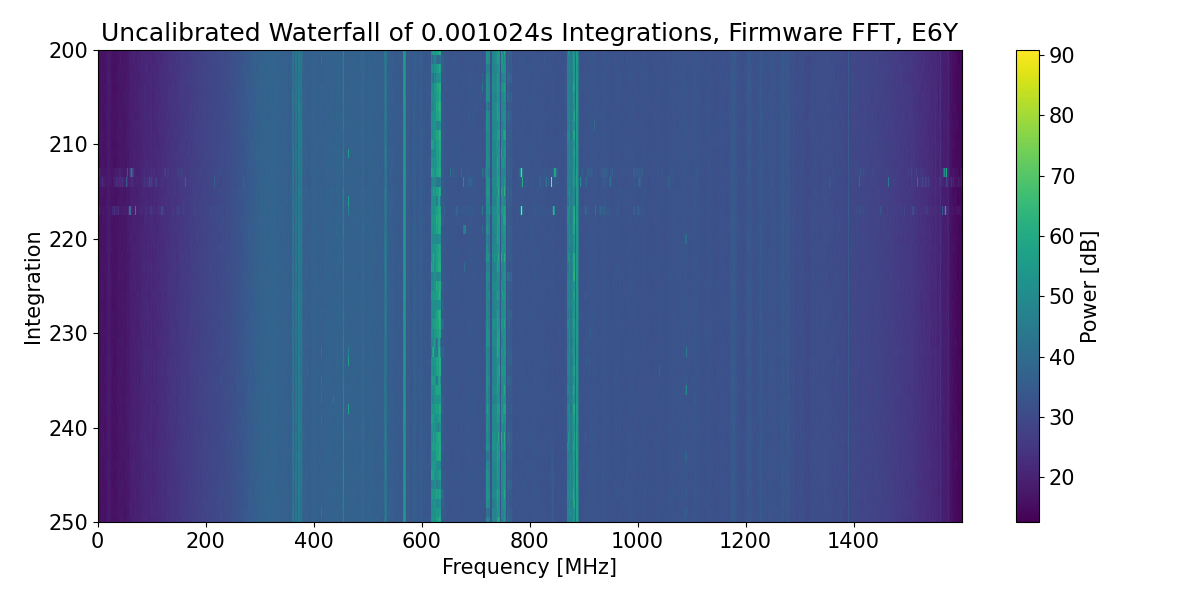

In [35]:
# Zoom in on a given input
pol = 2

plt.figure(figsize = (12, 6))
plt.title(f'Uncalibrated Waterfall of {fft_integration_period}s Integrations, Firmware FFT, {board_inputs[pol]}')
plt.pcolormesh(ccc.f, np.arange(n_fft_integrations), 10*np.log10(psd_fft[:, pol, :]))
plt.colorbar(label = 'Power [dB]')
plt.ylim(200, 250)
# plt.xlim(700, 725)
plt.ylabel('Integration')
plt.xlabel('Frequency [MHz]')
plt.gca().invert_yaxis()
plt.tight_layout()

In [24]:
%matplotlib widget

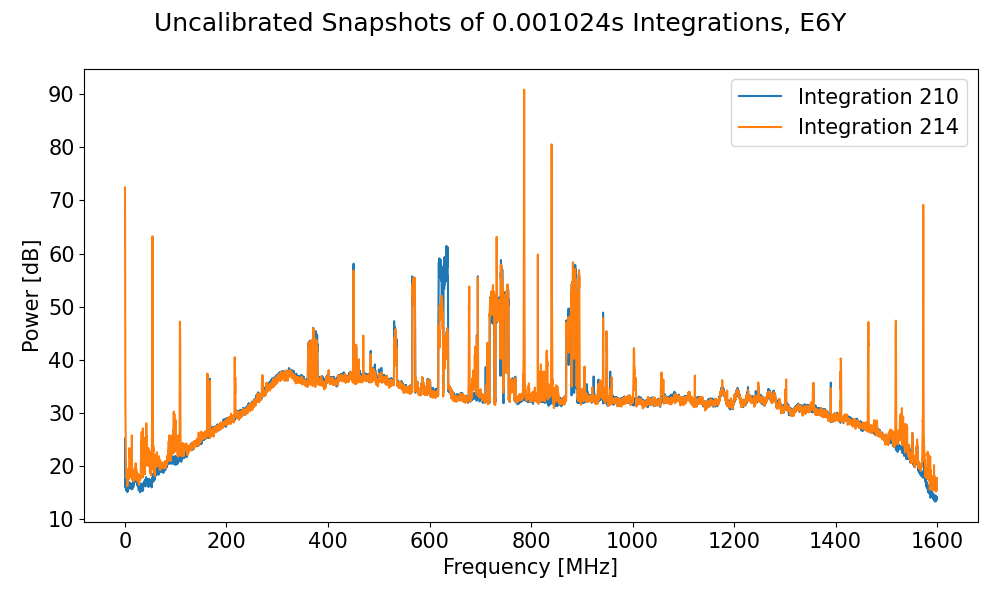

In [39]:
pol = 2
int_idx1 = 210
int_idx2 = 214

plt.figure(figsize = (10, 6))
plt.suptitle(f'Uncalibrated Snapshots of {fft_integration_period}s Integrations, {board_inputs[pol]}')
plt.plot(ccc.f, 10*np.log10(psd_fft[int_idx1, pol, :]), label = f'Integration {int_idx1}', color = 'C0')
plt.plot(ccc.f, 10*np.log10(psd_fft[int_idx2, pol, :]), label = f'Integration {int_idx2}', color = 'C1')
plt.ylabel('Power [dB]')
plt.xlabel('Frequency [MHz]')
plt.legend()
plt.tight_layout()

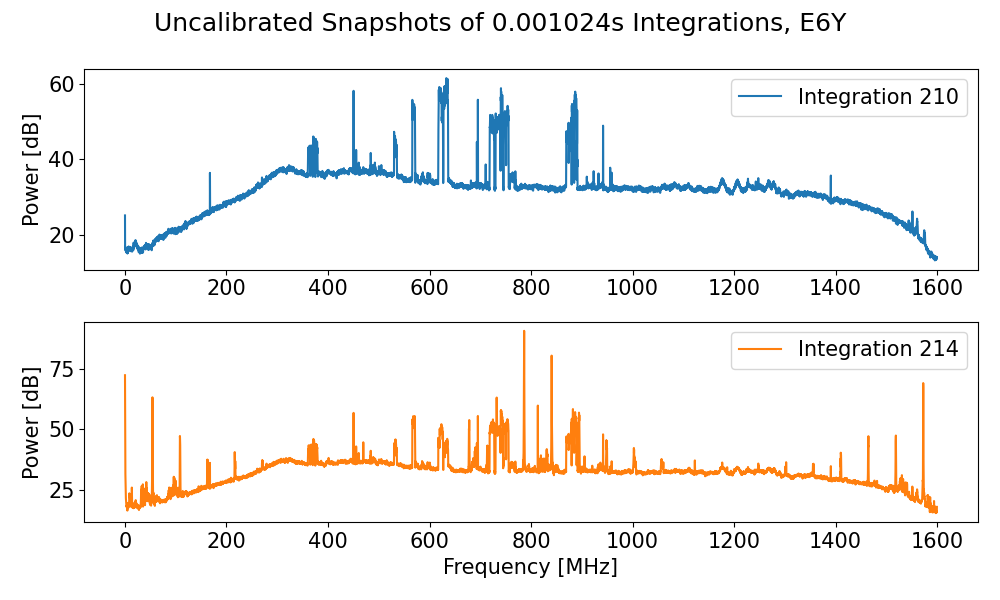

In [43]:
pol = 2
int_idx1 = 210
int_idx2 = 214

plt.figure(figsize = (10, 6))
plt.suptitle(f'Uncalibrated Snapshots of {fft_integration_period}s Integrations, {board_inputs[pol]}')
plt.subplot(211)
plt.plot(ccc.f, 10*np.log10(psd_fft[int_idx1, pol, :]), label = f'Integration {int_idx1}', color = 'C0')
plt.ylabel('Power [dB]')
plt.legend()
plt.subplot(212)
plt.plot(ccc.f, 10*np.log10(psd_fft[int_idx2, pol, :]), label = f'Integration {int_idx2}', color = 'C1')
plt.ylabel('Power [dB]')
plt.xlabel('Frequency [MHz]')
plt.legend()
plt.tight_layout()

In [27]:
ccc.f[np.where(10*np.log10(psd_fft[int_idx2, 2, :]) > 65)]

array([], dtype=float64)

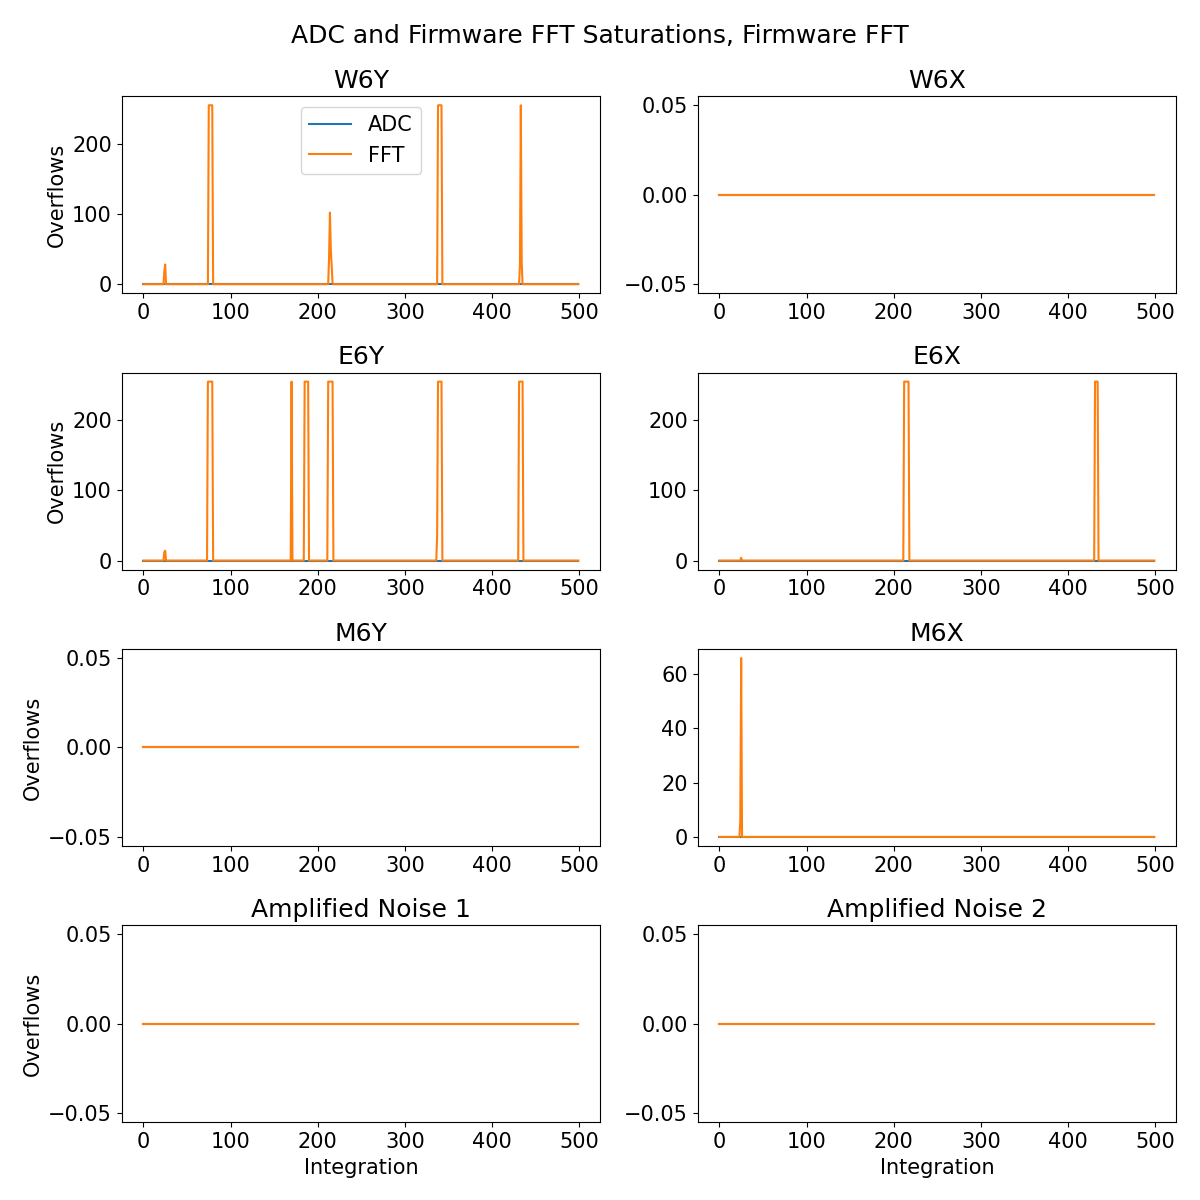

In [28]:
plt.figure(figsize = (12, 12))
plt.suptitle('ADC and Firmware FFT Saturations, Firmware FFT')
for n in range(ccc.NPOLS):
    plt.subplot(4, 2, n + 1)
    plt.title(f'{board_inputs[n]}')
    if n == 0:
        plt.plot(fft_cap_adc_ovflws[:, n], label = 'ADC')
        plt.plot(fft_cap_fft_ovflws[:, n], label = 'FFT')
        plt.legend()
    else:
        plt.plot(fft_cap_adc_ovflws[:, n])
        plt.plot(fft_cap_fft_ovflws[:, n])
    if n == 0 or n == 2 or n == 4 or n == 6:
        plt.ylabel('Overflows')
    if n == 6 or n== 7:
        plt.xlabel('Integration')
plt.tight_layout()

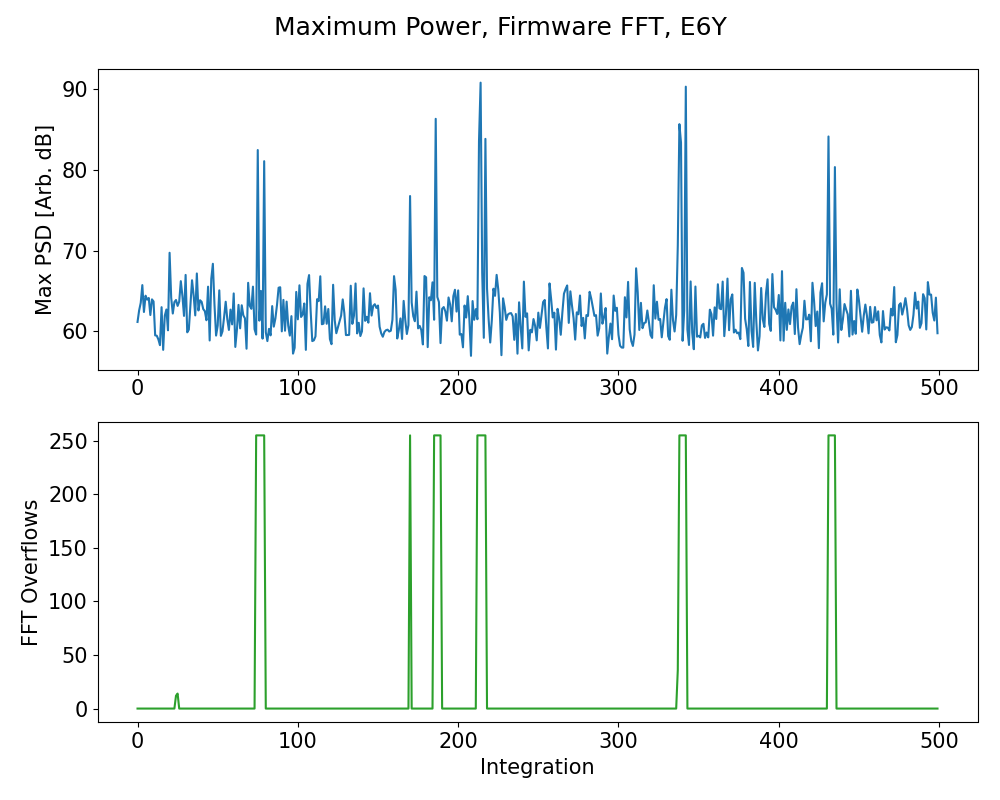

In [41]:
pol = 2
max_psd_fft = np.max(psd_fft, axis = 2)[:, pol]

plt.figure(figsize = (10, 8)) 
plt.suptitle(f'Maximum Power, Firmware FFT, {board_inputs[pol]}')
plt.subplot(211)
plt.plot(10*np.log10(max_psd_fft), color = 'C0')
plt.ylabel('Max PSD [Arb. dB]')
# plt.subplot(312)
# plt.plot(fft_cap_adc_ovflws[:, pol], color = 'C1')
# plt.ylabel('ADC Overflows')
plt.subplot(212)
plt.plot(fft_cap_fft_ovflws[:, pol], color = 'C2')
plt.ylabel('FFT Overflows')
plt.xlabel('Integration')
plt.tight_layout()

/tmp/ipykernel_536555/2964184170.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize = (12, 12))


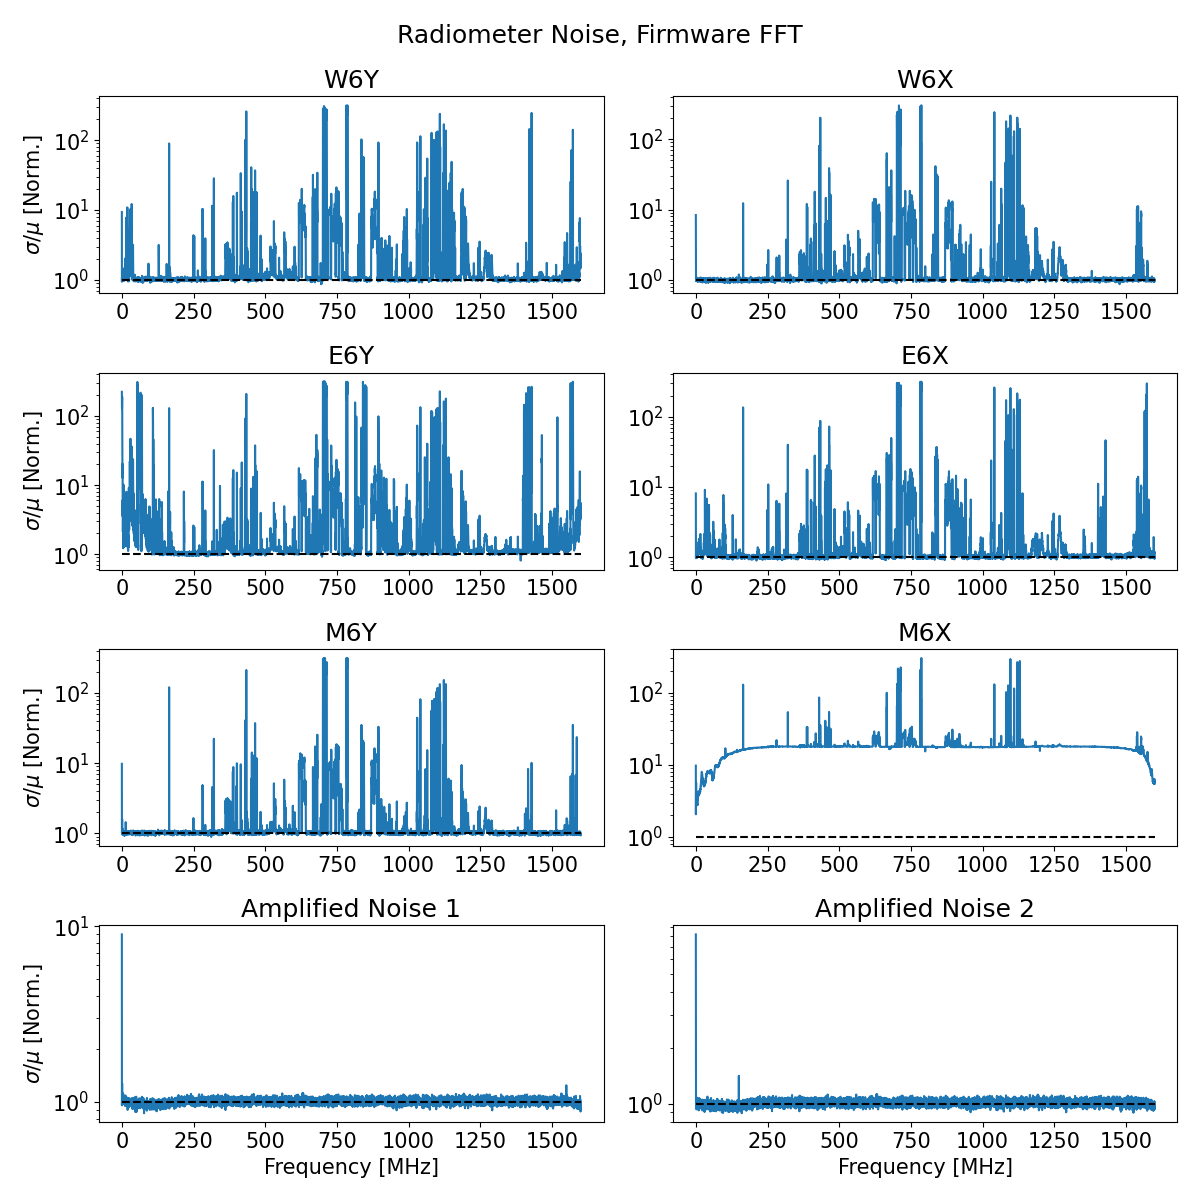

In [42]:
exp_fft_radiometer_ratio = 1/np.sqrt(fft_integration_period*(3200/16384)*1e6) # s * (3200 MSPS / 16384 S) * 1e6 [S/MS]

sigma_psd_fft = np.std(psd_fft, axis = 0)
mean_psd_fft = np.mean(psd_fft, axis = 0)
rad_ratio_fft = sigma_psd_fft/mean_psd_fft

plt.figure(figsize = (12, 12))
plt.suptitle('Radiometer Noise, Firmware FFT')

for n in range(ccc.NPOLS):
    plt.subplot(4, 2, n + 1)
    plt.title(f'{board_inputs[n]}')
    plt.semilogy(ccc.f, rad_ratio_fft[n]/exp_fft_radiometer_ratio)
    plt.hlines(1, ccc.f[0], ccc.f[-1], color = 'black', linestyle = '--')
    if n == 0 or n == 2 or n == 4 or n == 6:
        plt.ylabel('$\sigma / \mu$ [Norm.]')
    if n == 6 or n== 7:
        plt.xlabel('Frequency [MHz]')
plt.tight_layout()

In [31]:
psd_fft.shape

(500, 8, 8192)

In [32]:
np.where(fft_cap_fft_ovflws[:, 0] == 0)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
         41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
         54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
         67,  68,  69,  70,  71,  72,  73,  74,  80,  81,  82,  83,  84,
         85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110,
        111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123,
        124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136,
        137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149,
        150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162,
        163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175,
        176, 177, 178, 179, 180, 181, 182, 183, 184

In [33]:
psd_fft[np.where(fft_cap_fft_ovflws[:, 0] == 0)[0], 0].shape

(480, 8192)

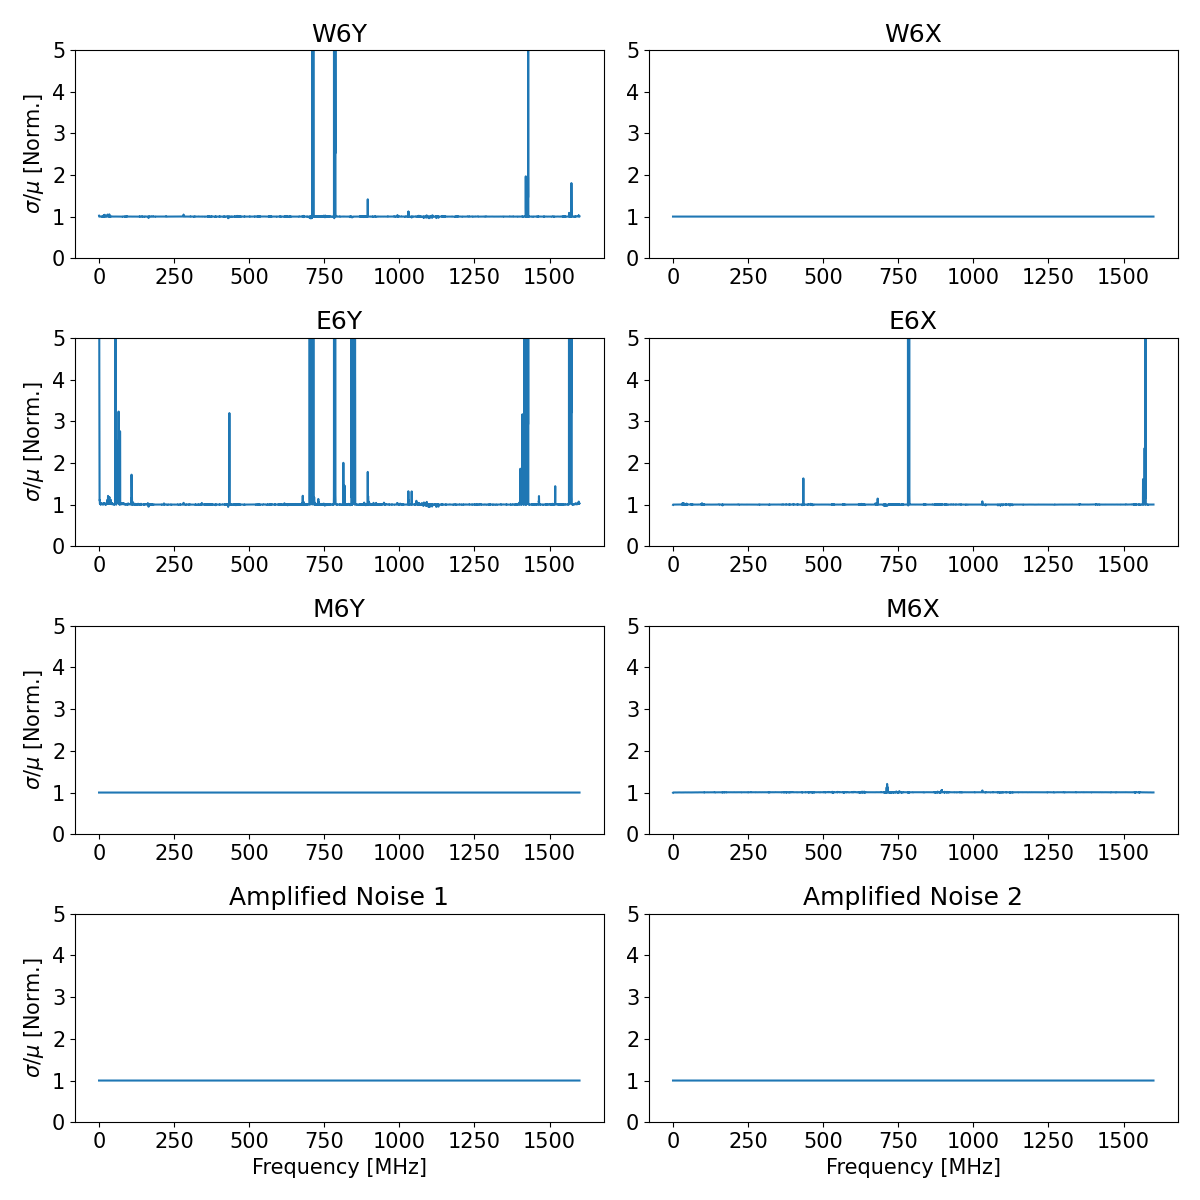

In [34]:
plt.figure(figsize = (12, 12))

for n in range(ccc.NPOLS):
    plt.subplot(4, 2, n + 1)
    plt.title(f'{board_inputs[n]}')
    plt.plot(ccc.f, np.mean(psd_fft[:, n], axis = 0)/np.mean(psd_fft[np.where(fft_cap_fft_ovflws[:, n] == 0)[0], n], axis = 0), label = f'Pol {n}')
    if n == 0 or n == 2 or n == 4 or n == 6:
        plt.ylabel('$\sigma / \mu$ [Norm.]')
    if n == 6 or n== 7:
        plt.xlabel('Frequency [MHz]')
    plt.ylim(0, 5)
plt.tight_layout()

In [39]:
import h5py

In [40]:
# file = h5py.File('firmware_fft_psd_and_kertosis_20240405.hdf5', 'w')

In [44]:
file.create_dataset('frequency', (len(ccc.f), ))

<HDF5 dataset "frequency": shape (8192,), type "<f4">

In [45]:
file['frequency'][:] = ccc.f

In [47]:
file.create_dataset('psd', psd_fft.shape)

<HDF5 dataset "psd": shape (500, 8, 8192), type "<f4">

In [49]:
file['psd'][:] = psd_fft

In [53]:
del file['board_inputs']

In [54]:
file.keys()

<KeysViewHDF5 ['frequency', 'psd']>

In [55]:
file.create_dataset('kertosis', kert_fft.shape)

<HDF5 dataset "kertosis": shape (500, 8, 8192), type "<f4">

In [56]:
file['kertosis'][:] = kert_fft

In [57]:
file['kertosis'].attrs['board_inputs'] = board_inputs

In [58]:
file['kertosis'].attrs['integration_period'] = fft_integration_period

In [61]:
file.create_dataset('adc_overflows', fft_cap_adc_ovflws.shape)

<HDF5 dataset "adc_overflows": shape (500, 8), type "<f4">

In [62]:
file['adc_overflows'][:] = fft_cap_adc_ovflws

In [63]:
file.create_dataset('fft_overflows', fft_cap_fft_ovflws.shape)

<HDF5 dataset "fft_overflows": shape (500, 8), type "<f4">

In [64]:
file['fft_overflows'][:] = fft_cap_fft_ovflws

In [65]:
file.keys()

<KeysViewHDF5 ['adc_overflows', 'fft_overflows', 'frequency', 'kertosis', 'psd']>

In [68]:
file.close()